# Verify behavior cloning

Visually verify a behavior cloning based robot controller.

* Load the controller trained by the Train_BC notebook and the corresponding sp
* Choose a demonstration, to which the SP/BC pair will be applied to the images
* Visualize the path taken by the demonstration and what would be (autoregressively) recommended by the controller

In [1]:
import sys
sys.path.append("..")

from exp_run_config import Config
Config.PROJECTNAME = "BerryPicker"

import pathlib
import pprint
import matplotlib.pyplot as plt
# fixing the fact that it defaults to Type 3 fonts
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import torch
# import torch.nn as nn
# import torch.optim as optim
import numpy as np

from bc_factory import create_bc_model
# FIXME: factor this out
from bc_LSTM_MDN import bc_LSTM_MDN, mdn_loss

torch.manual_seed(1)
from sensorprocessing.sp_helper import get_transform_to_sp
from sensorprocessing.sp_factory import create_sp
from demonstration.demonstration import Demonstration

from robot.al5d_position_controller import RobotPosition
import bc_factory 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.13_3.13.2544.0_x64__qbz5n2kfra8p0\Lib\pathlib\__init__.py
***ExpRun**: Loading pointer config file:
	C:\Users\lotzi\.config\BerryPicker\mainsettings.yaml
***ExpRun**: Loading machine-specific config file:
	c:\Users\lotzi\Work\_Config\BerryPicker\cfg\settings.yaml
Using device: cuda


In [2]:
# *** Initialize the variables with default values 
# *** This cell should be tagged as parameters     
# *** If papermill is used, some of the values will be overwritten 

# If it is set to true, the exprun will be recreated from scratch
creation_style = "exist-ok"

# If not None, set an external experiment path
external_path = None

# If not None, set an output path
data_path = None



experiment = "behavior_cloning"
run = None
# run = "bc_verify_mlp_00"
# run = "bc_verify_lstm_00"
# run = "bc_verify_lstm_resid_00"
# run = "bc_verify_lstm_mdn_00"


# **** The settings below are used to debug a particular run in flow 
# **** They do not affect the run of the flow, 
# **** because they are going to be overwritten by papermill
data_path = "c:/Users/lotzi/Work/_Data/BerryPicker-Flows/BerryPicker-BC/result"
experiment = "behavior_cloning"
external_path = "c:/Users/lotzi/Work/_Data/BerryPicker-Flows/BerryPicker-BC/exprun"
run = "bc_mlp_0001_verify"



In [3]:
if external_path:
    external_path = pathlib.Path(external_path)
    assert external_path.exists()
    Config().set_exprun_path(external_path)
    Config().copy_experiment("sensorprocessing_conv_vae")
    Config().copy_experiment("robot_al5d")
    Config().copy_experiment("demonstration")
    Config().copy_experiment("behavior_cloning")
if data_path:
    data_path = pathlib.Path(data_path)
    assert data_path.exists()
    Config().set_results_path(data_path)
    
# temporary solution
# Setting up a separate directory for generated and computed data

exp = Config().get_experiment(experiment, run, creation_style=creation_style)
pprint.pprint(exp)

# Create the sp object described in the experiment
exp_sp = Config().get_experiment(exp["exp_sp"], exp["run_sp"])
sp = create_sp(exp_sp, device)
transform = get_transform_to_sp(exp_sp)

exp_robot = Config().get_experiment(exp["exp_robot"], exp["run_robot"])

# Load the bc model described in the experiment
exp_bc = Config().get_experiment(exp["exp_bc"], exp["run_bc"])
model, _, _ = create_bc_model(exp_bc, exp_sp, device)
model_path = pathlib.Path(exp_bc.data_dir(), exp_bc["controller_file"])
model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))   
# model.load_state_dict(torch.load(model_path))

***ExpRun**: Experiment config path changed to c:\Users\lotzi\Work\_Data\BerryPicker-Flows\BerryPicker-BC\exprun
***ExpRun**: Experiment sensorprocessing_conv_vae copied to
c:\Users\lotzi\Work\_Data\BerryPicker-Flows\BerryPicker-BC\exprun\sensorprocessing_conv_vae
***ExpRun**: Experiment robot_al5d copied to
c:\Users\lotzi\Work\_Data\BerryPicker-Flows\BerryPicker-BC\exprun\robot_al5d
***ExpRun**: Experiment demonstration copied to
c:\Users\lotzi\Work\_Data\BerryPicker-Flows\BerryPicker-BC\exprun\demonstration
***ExpRun**: Experiment behavior_cloning copied to
c:\Users\lotzi\Work\_Data\BerryPicker-Flows\BerryPicker-BC\exprun\behavior_cloning
***ExpRun**: Experiment data path changed to c:\Users\lotzi\Work\_Data\BerryPicker-Flows\BerryPicker-BC\result
***ExpRun**: Configuration for exp/run: behavior_cloning/bc_mlp_0001_verify successfully loaded
Experiment:
    batch_size: 64
    control_size: 6
    data_dir: c:\Users\lotzi\Work\_Data\BerryPicker-Flows\BerryPicker-BC\result\behavior_clon

<All keys matched successfully>

In [4]:
pred_path = pathlib.Path(exp.data_dir(), "pred.npy")
real_path = pathlib.Path(exp.data_dir(), "real.npy")

if pred_path.exists():
    a_pred_np = np.load(pred_path)
    a_real_np = np.load(real_path)
    print(f"Paths successfully loaded from\n{pred_path.relative_to(pathlib.Path.home())}")
else:
    a_real_list = []
    a_pred_list = []
    with torch.no_grad(): # disable gradient computation
        for val in exp["verification_data"]: # for all demonstrations
            run, demo_name, camera = val
            exp_demo = Config().get_experiment("demonstration", run)
            demo = Demonstration(exp_demo, demo_name)
            for i in range(demo.metadata["maxsteps"]-exp_bc["sequence_length"]): # -1 because of lookahead
                if exp_bc["sequence_length"]:
                    input_list = []
                    # FIXME make it sliding window
                    for j in range(exp_bc["sequence_length"]):
                        sensor_readings, _ = demo.get_image(i+j, device=device, transform=transform, camera=camera)
                        if sensor_readings is not None:
                            print(f"reading {i+j} successful")
                        else:
                            print(f"reading {i+j} not successful, returned none")
                        z = sp.process(sensor_readings)
                        input_list.append(z)
                        input_nd = np.array(input_list)
                        z_tensor = torch.tensor(input_nd).unsqueeze(0).to(device)
                else:
                    sensor_readings, _ = demo.get_image(i, device=device, transform=transform, camera=camera)
                    z = sp.process(sensor_readings)
                    z_tensor = torch.tensor(z).unsqueeze(0).to(device)
                if not isinstance(model, bc_LSTM_MDN):                
                    a_pred = model(z_tensor)
                else:
                    a_pred = model.forward_and_sample(z_tensor)
                a_pred_list.append(a_pred.to("cpu").squeeze(0))
                rp = demo.get_action(i, "rc-position-target", exp_robot)
                # a = demo.get_action(i)
                # rp = RobotPosition.from_vector(exp_robot, a)
                a_real = rp.to_normalized_vector(exp_robot)            
                a_real_list.append(a_real)
    a_pred_np = np.array(a_pred_list)
    a_real_np = np.array(a_real_list)

    # save the comparison terms
    np.save(pred_path, a_pred_np)
    np.save(real_path, a_real_np)            

***ExpRun**: Configuration for exp/run: demonstration/automove-pack-01 successfully loaded
reading 0 successful
reading 1 successful
reading 2 successful
reading 3 successful
reading 4 successful
reading 5 successful
reading 6 successful
reading 7 successful
reading 8 successful
reading 9 successful
reading 10 successful
reading 11 successful
reading 12 successful
reading 13 successful
reading 14 successful
reading 15 successful
reading 16 successful
reading 17 successful
reading 18 successful
reading 19 successful
reading 20 successful
reading 21 successful
reading 22 successful
reading 23 successful
reading 24 successful
reading 25 successful
reading 26 successful
reading 27 successful
reading 28 successful
reading 29 successful
reading 30 successful
reading 31 successful
reading 32 successful
reading 33 successful
reading 34 successful
reading 35 successful
reading 36 successful
reading 37 successful
reading 38 successful
reading 39 successful
reading 40 successful
reading 41 succes

## Plot the differences between the a_real and a_pred

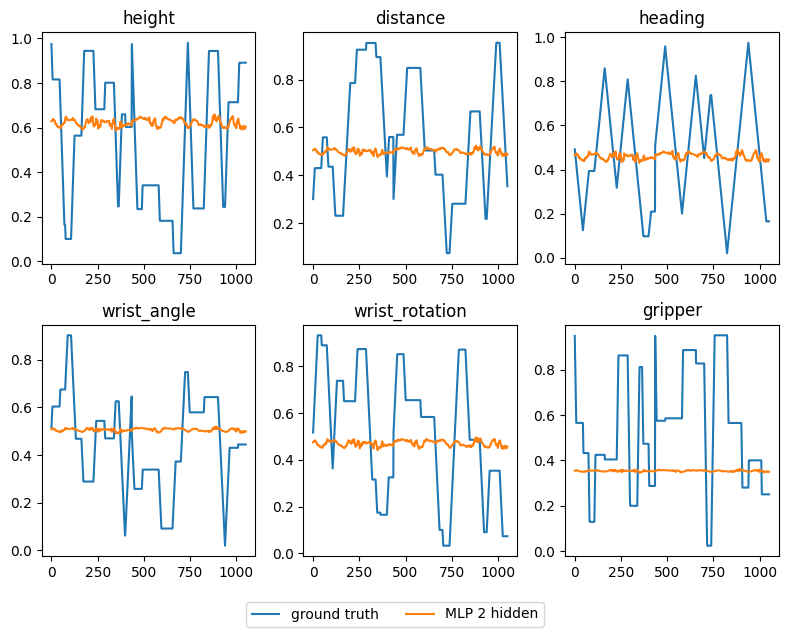

In [5]:

fig, axs = plt.subplots(2,3, figsize=(8, 6))
titles = ["height","distance", "heading", "wrist_angle", "wrist_rotation", "gripper"]
for i in range(exp_bc["control_size"]):
    ax = axs[i//3, i%3]
    #ax.set_ylim(0, 1.4)
    ax.plot(a_real_np[:,i], label="ground truth")
    if len(a_pred_np.shape) == 3:
        ax.plot(a_pred_np[:,0,i], label=exp_bc["name"])
    else:
        ax.plot(a_pred_np[:,i], label=exp_bc["name"])
    if i==0:
        handles, labels = ax.get_legend_handles_labels()
        fig.legend(handles, labels, ncol=2,
            bbox_to_anchor=(0.5, 0), loc="upper center")
    ax.set_title(titles[i])

plt.tight_layout()
graphfilename = pathlib.Path(exp.data_dir(), "bccomparison.pdf")
plt.savefig(graphfilename, bbox_inches='tight')

In [6]:
# print(exp_bc)

a_real_np.shape
# a_real_np[:,1]

(1052, 6)

In [7]:
len(a_pred_np.shape)

3

In [8]:
exp_bc

Experiment:
    batch_size: 64
    control_size: 6
    controller: bc_MLP
    controller_file: controller.pth
    data_dir: c:\Users\lotzi\Work\_Data\BerryPicker-Flows\BerryPicker-BC\result\behavior_cloning\bc_mlp_0001
    epochs: 15
    exp_robot: robot_al5d
    exp_run_sys_indep_file: c:\Users\lotzi\Work\_Data\BerryPicker-Flows\BerryPicker-BC\exprun\behavior_cloning\bc_mlp_0001.yaml
    exp_sp: sensorprocessing_conv_vae
    experiment_name: behavior_cloning
    hidden_layer_1: 50
    hidden_layer_2: 20
    hidden_layers: 2
    latent_size: 128
    loss: MSELoss
    name: MLP 2 hidden
    optimizer: Adam
    optimizer_lr: 0.001
    run_name: bc_mlp_0001
    run_robot: position_controller_00
    run_sp: sp_conv_vae_0001
    sequence_length: 1
    subrun_name: null
    training_data:
    - - automove-pack-01
      - bc_training_00000
      - dev2
    - - automove-pack-01
      - bc_training_00001
      - dev2
    - - automove-pack-01
      - bc_training_00002
      - dev2
    - - automo